<a href="https://colab.research.google.com/github/iam-pattan/Exploring-DL/blob/master/NASNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://analyticsindiamag.com/transfer-learning-using-tensorflow-keras/

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt 

In [2]:
data, meta = tfds.load('oxford_flowers102', 
                      as_supervised=True,
                      with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete10HV1Y/oxford_flowers102-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete10HV1Y/oxford_flowers102-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete10HV1Y/oxford_flowers102-validation.tfrecord


Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [3]:
raw_train = data['train']
raw_val = data['validation']
raw_test = data['test']

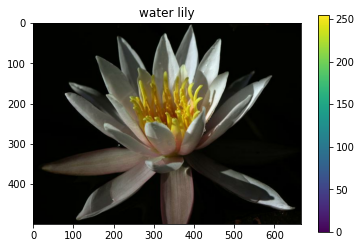

In [4]:
label_extractor = meta.features['label'].int2str
for image,label in raw_train.take(1):
  plt.imshow(image)
  plt.title(label_extractor(label))
  plt.colorbar()
  plt.show()

In [5]:
print(image.shape)
min(image.numpy().ravel()), max(image.numpy().ravel()) 

(500, 667, 3)


(0, 255)

In [6]:
base = keras.applications.NASNetLarge(input_shape=(331,331,3),
                                      include_top=False,
                                      weights='imagenet') 

343613440/343610240 [==============================] - 3s 0us/step


In [7]:
def scale_image(img,label):
  img = tf.cast(img,tf.float32)
  img = img/255.0
  img = tf.image.resize(img, (331,331))
  return img,label 

In [8]:
train = raw_train.map(scale_image)
val = raw_val.map(scale_image)
test = raw_test.map(scale_image) 

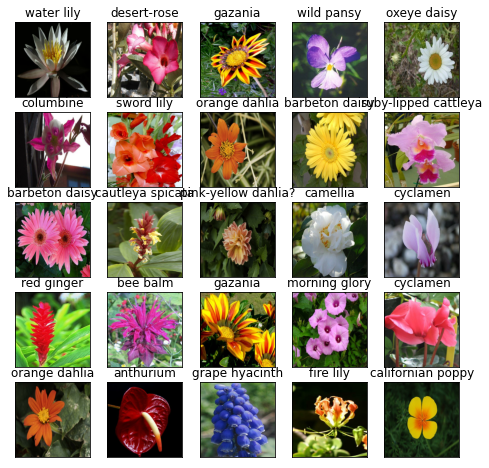

In [9]:
plt.figure(figsize=(8,8))
i=1
for img, label in train.take(25):
  plt.subplot(5,5,i)
  plt.imshow(img)
  plt.title(label_extractor(label))
  plt.xticks([])
  plt.yticks([])
  i += 1
plt.show() 

In [10]:
batch_size = 64
train_batches = train.batch(batch_size)
val_batches = val.batch(batch_size)

In [11]:
base.trainable=False

In [12]:
head = keras.models.Sequential([
                                keras.layers.GlobalAveragePooling2D(),
                                keras.layers.Dense(512, activation='relu'),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(4, activation='softmax')
])

In [13]:
model = keras.models.Sequential([base,head])

In [14]:
base.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [15]:
head.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2064896   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 2,066,948
Trainable params: 2,066,948
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
sequential (Sequential)      (None, 4)                 2066948   
Total params: 86,983,766
Trainable params: 2,066,948
Non-trainable params: 84,916,818
_________________________________________________________________


In [23]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

In [24]:
history = model.fit(train_batches, validation_data=val_batches, epochs=100, callbacks=callback)

Epoch 1/100
16/16 [==============================] - 72s 4s/step - loss: nan - accuracy: 0.0107 - val_loss: nan - val_accuracy: 0.0098
Epoch 2/100
16/16 [==============================] - 56s 4s/step - loss: nan - accuracy: 0.0107 - val_loss: nan - val_accuracy: 0.0098
Epoch 3/100
16/16 [==============================] - 58s 4s/step - loss: nan - accuracy: 0.0107 - val_loss: nan - val_accuracy: 0.0098


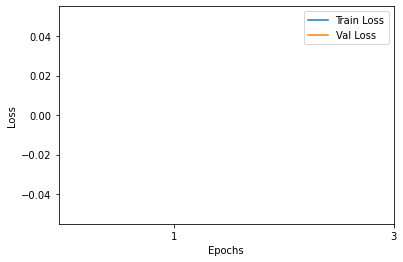

In [20]:
hist = pd.DataFrame(history.history)
length = len(hist['loss'])
epochs = np.arange(1,length+1)

plt.plot(epochs,hist['loss'], label='Train Loss')
plt.plot(epochs,hist['val_loss'], label='Val Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(1,length+1,2))
plt.show() 

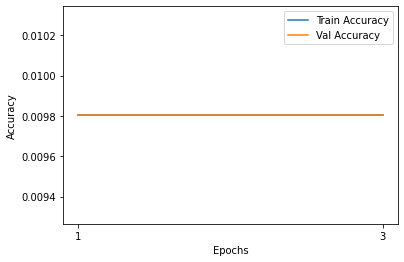

In [21]:
plt.plot(epochs,hist['accuracy'], label='Train Accuracy')
plt.plot(epochs,hist['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(1,length+1,2))
plt.show() 